<a href="https://colab.research.google.com/github/haidour18/Benchemarking-Recommender-systems-/blob/main/Kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
!pip install -q keras
!pip install numpy
!pip install sklearn
!pip install scipy
!pip install surprise
!pip install apyori
!pip install matrix_factorization
!pip install factor-analyzer
!pip install python-helper

     |████████████████████████████████| 11.8MB 351kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1615290 sha256=e86592b50d28a5a898bd773f177c4ab556abf1fb1be42a232c4901b33d9d3b27
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise
  Created wheel for apyori: filename=apyori-1.1.2-cp37-none-any.whl size=5975 sha256=b412a21b8b89ae9d60ed90d88e57973565bb65366ab667940710a37f9293b68b
  Stored in directory: /root/.cache/pip/wheels/5d/92/bb/474bbadbc8c0062b9eb168f69982a0443263f8ab1711a8cad0
Successfully built apyori
     |████████████████████████████████| 22.3MB 1.4MB/s 
  Created wheel for matrix-factorization: filename=matrix_factorization-1.3-cp37-none-any.whl size=16468 sha256=497ec67882605a7695bddddc4f3f97a1c959e2b6a4a42b1f6a7a311cb54fb620
  Stored in directory: /root/.cache/pip/wheels/db/ef/99/19df32b6eb88678b0e3a42d2e24955e7753b2de44615111ba

In [2]:
#All the header files required for the code
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
import helper
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, glob , csv
import time, joblib
import pandas as pd
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import seaborn as sns
from zipfile import ZipFile as zip
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

from IPython.display import display
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics.pairwise import cosine_similarity as cos
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import precision_score
import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt

In [3]:
from google.colab import files 
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
#change permissions 
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
!kaggle datasets download -d rounakbanik/the-movies-dataset


 94% 215M/228M [00:01<00:00, 125MB/s]
100% 228M/228M [00:01<00:00, 120MB/s]


In [5]:
# Dézippier le .zip obtenu
from zipfile import ZipFile
file_name = 'the-movies-dataset.zip'
with ZipFile (file_name ,'r') as zip : 
  zip.extractall()
  print('Done')

Done


In [6]:

ratings=pd.read_csv("ratings.csv")
ratings.head(4)


,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546


In [7]:

print('Shape of ratings dataset is: ',ratings.shape, '\n')
print('Max values in dataset are \n',ratings.max(), '\n')
print('Min values in dataset are \n',ratings.min(), '\n')

Shape of ratings dataset is:  (26024289, 4) 

Max values in dataset are 
 userId       2.708960e+05
movieId      1.762750e+05
rating       5.000000e+00
timestamp    1.501830e+09
dtype: float64 

Min values in dataset are 
 userId               1.0
movieId              1.0
rating               0.5
timestamp    789652004.0
dtype: float64 



In [8]:
# Filtering data for only 4+ ratings
ratings = ratings[ratings['rating'] >= 4.0]
print('Shape of ratings dataset is: ',ratings.shape, '\n')
print('Max values in dataset are \n',ratings.max(), '\n')
print('Min values in dataset are \n',ratings.min(), '\n')

Shape of ratings dataset is:  (12981742, 4) 

Max values in dataset are 
 userId       2.708960e+05
movieId      1.762710e+05
rating       5.000000e+00
timestamp    1.501829e+09
dtype: float64 

Min values in dataset are 
 userId               1.0
movieId              1.0
rating               4.0
timestamp    789652004.0
dtype: float64 



In [9]:
movies_list = np.unique(ratings['movieId'])[:200]
ratings = ratings.loc[ratings['movieId'].isin(movies_list)]
print('Shape of ratings dataset is: ',ratings.shape, '\n')
print('Max values in dataset are \n',ratings.max(), '\n')
print('Min values in dataset are \n',ratings.min(), '\n')

Shape of ratings dataset is:  (776269, 4) 

Max values in dataset are 
 userId       2.708960e+05
movieId      2.010000e+02
rating       5.000000e+00
timestamp    1.501823e+09
dtype: float64 

Min values in dataset are 
 userId               1.0
movieId              1.0
rating               4.0
timestamp    789652009.0
dtype: float64 



In [11]:
users_fav_movies = ratings.loc[:, ['userId', 'movieId']]


In [12]:
users_fav_movies = ratings.reset_index(drop = True)
users_fav_movies.head(4)

,userId,movieId,rating,timestamp
0,1,147,4.5,1425942435
1,2,64,4.0,867039612
2,2,79,4.0,867039325
3,8,1,4.0,1013443596


In [13]:
users_fav_movies.T


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,776229,776230,776231,776232,776233,776234,776235,776236,776237,776238,776239,776240,776241,776242,776243,776244,776245,776246,776247,776248,776249,776250,776251,776252,776253,776254,776255,776256,776257,776258,776259,776260,776261,776262,776263,776264,776265,776266,776267,776268
userId,1.000000e+00,2.0,2.0,8.000000e+00,8.000000e+00,9.000000e+00,9.000000e+00,10.0,10.0,1.100000e+01,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,1.500000e+01,1.600000e+01,1.600000e+01,1.600000e+01,1.600000e+01,18.0,2.000000e+01,2.000000e+01,2.000000e+01,2.000000e+01,2.200000e+01,2.200000e+01,24.0,24.0,...,2.708870e+05,2.708870e+05,2.708870e+05,2.708870e+05,2.708870e+05,2.708870e+05,2.708870e+05,2.708870e+05,2.708870e+05,270891.0,270891.0,270891.0,270891.0,270891.0,270891.0,270891.0,2.708920e+05,2.708920e+05,2.708920e+05,270893.0,270893.0,270893.0,270893.0,270893.0,270893.0,270893.0,2.708940e+05,270895.0,270895.0,270895.0,270895.0,2.708960e+05,2.708960e+05,2.708960e+05,2.708960e+05,2.708960e+05,2.708960e+05,2.708960e+05,2.708960e+05,2.708960e+05
movieId,1.470000e+02,64.0,79.0,1.000000e+00,4.700000e+01,1.000000e+00,1.500000e+02,150.0,165.0,3.400000e+01,1.0,16.0,17.0,29.0,34.0,47.0,50.0,82.0,97.0,123.0,125.0,150.0,162.0,175.0,176.0,194.0,6.000000e+00,3.200000e+01,5.000000e+01,1.110000e+02,1.980000e+02,81.0,1.000000e+00,3.900000e+01,1.500000e+02,1.610000e+02,1.100000e+02,1.630000e+02,1.0,6.0,...,1.500000e+02,1.600000e+02,1.610000e+02,1.650000e+02,1.850000e+02,1.900000e+02,1.930000e+02,1.960000e+02,2.000000e+02,7.0,11.0,62.0,110.0,140.0,150.0,161.0,1.000000e+00,3.200000e+01,5.000000e+01,1.0,34.0,47.0,50.0,70.0,110.0,165.0,4.700000e+01,34.0,110.0,150.0,161.0,1.000000e+00,1.700000e+01,2.500000e+01,3.200000e+01,3.600000e+01,4.700000e+01,5.000000e+01,1.100000e+02,1.110000e+02
rating,4.500000e+00,4.0,4.0,4.000000e+00,4.000000e+00,4.500000e+00,4.000000e+00,4.0,4.0,4.000000e+00,4.0,4.0,4.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,5.0,4.000000e+00,4.500000e+00,5.000000e+00,5.000000e+00,4.500000e+00,5.0,4.000000e+00,5.000000e+00,4.000000e+00,4.000000e+00,5.000000e+00,4.000000e+00,4.0,4.0,...,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,4.000000e+00,5.000000e+00,5.000000e+00,4.0,4.0,5.0,5.0,4.0,5.0,4.0,4.000000e+00,4.000000e+00,4.000000e+00,4.0,4.0,5.0,5.0,4.0,5.0,4.0,4.000000e+00,4.0,4.0,5.0,4.0,4.500000e+00,4.000000e+00,4.000000e+00,5.000000e+00,4.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
timestamp,1.425942e+09,867039612.0,867039325.0,1.013444e+09,1.013444e+09,1.073837e+09,1.073837e+09,846287850.0,846288047.0,1.231677e+09,943912205.0,943913329.0,943911191.0,943913115.0,943913044.0,943912317.0,943911078.0,943911115.0,943911285.0,943912719.0,943912278.0,943913006.0,943911613.0,943911842.0,943912719.0,943912278.0,1.346008e+09,1.485646e+09,1.485651e+09,1.485646e+09,1.485647e+09,965665345.0,1.368361e+09,1.492184e+09,1.432292e+09,1.419976e+09,1.111937e+09,1.111937e+09,979869938.0,979870499.0,...,1.463274e+09,1.463494e+09,1.463494e+09,1.463003e+09,1.463274e+09,1.463535e+09,1.479322e+09,1.463778e+09,1.463580e+09,835259142.0,834405964.0,834405854.0,834405826.0,834405982.0,834405580.0,834405897.0,1.226040e+09,1.226040e+09,1.226040e+09,992896512.0,992896475.0,992332943.0,992332590.0,992417683.0,992417240.0,992332772.0,1.419821e+09,845432277.0,845432120.0,845431989.0,845432120.0,1.257031e+09,1.257034e+09,1.257034e+09,1.257032e+09,1.257034e+09,1.257032e+09,1.257032e+09,1.257031e+09,1.257034e+09


In [17]:
users_fav_movies.to_csv('/content/cleandata.csv')


In [18]:
def moviesListForUsers(users, users_data):
    # users = a list of users IDs
    # users_data = a dataframe of users favourite movies or users watched movies
    users_movies_list = []
    for user in users:
        users_movies_list.append(str(list(users_data[users_data['userId'] == user]['movieId'])).split('[')[1].split(']')[0])
    return users_movies_list

In [19]:
users = np.unique(users_fav_movies['userId'])
print(users.shape)

(162976,)


In [20]:
users_movies_list = moviesListForUsers(users, users_fav_movies)
print('Movies list for', len(users_movies_list), ' users')
print('A list of first 10 users favourite movies: \n', users_movies_list[:10])

Movies list for 162976  users
A list of first 10 users favourite movies: 
 ['147', '64, 79', '1, 47', '1, 150', '150, 165', '34', '1, 16, 17, 29, 34, 47, 50, 82, 97, 123, 125, 150, 162, 175, 176, 194', '6', '32, 50, 111, 198', '81']


In [21]:
def prepSparseMatrix(list_of_str):
    # list_of_str = A list, which contain strings of users favourite movies separate by comma ",".
    # It will return us sparse matrix and feature names on which sparse matrix is defined 
    # i.e. name of movies in the same order as the column of sparse matrix
    cv = CountVectorizer(token_pattern = r'[^\,\ ]+', lowercase = False)
    sparseMatrix = cv.fit_transform(list_of_str)
    return sparseMatrix.toarray(), cv.get_feature_names()

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

sparseMatrix, feature_names = prepSparseMatrix(users_movies_list)


In [23]:
df_sparseMatrix = pd.DataFrame(sparseMatrix, index = users, columns = feature_names)
df_sparseMatrix

,1,10,100,101,102,103,104,105,106,107,108,109,11,110,111,112,113,114,115,116,117,118,119,12,120,121,122,123,124,125,126,127,128,129,13,130,131,132,133,134,...,62,63,64,65,66,67,68,69,7,70,71,72,73,74,75,76,77,78,79,8,80,81,82,83,84,85,86,87,88,89,9,90,92,93,94,95,96,97,98,99
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270892,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
270893,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
270894,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
270895,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
first_6_users_SM = users_fav_movies[users_fav_movies['userId'].isin(users[:6])].sort_values('userId')
first_6_users_SM.T

,0,1,2,3,4,5,6,7,8,9
userId,1.000000e+00,2.0,2.0,8.000000e+00,8.000000e+00,9.000000e+00,9.000000e+00,10.0,10.0,1.100000e+01
movieId,1.470000e+02,64.0,79.0,1.000000e+00,4.700000e+01,1.000000e+00,1.500000e+02,150.0,165.0,3.400000e+01
rating,4.500000e+00,4.0,4.0,4.000000e+00,4.000000e+00,4.500000e+00,4.000000e+00,4.0,4.0,4.000000e+00
timestamp,1.425942e+09,867039612.0,867039325.0,1.013444e+09,1.013444e+09,1.073837e+09,1.073837e+09,846287850.0,846288047.0,1.231677e+09


In [25]:
df_sparseMatrix.loc[np.unique(first_6_users_SM['userId']), list(map(str, np.unique(first_6_users_SM['movieId'])))]


,1,34,47,64,79,147,150,165
1,0,0,0,0,0,1,0,0
2,0,0,0,1,1,0,0,0
8,1,0,1,0,0,0,0,0
9,1,0,0,0,0,0,1,0
10,0,0,0,0,0,0,1,1
11,0,1,0,0,0,0,0,0


Clustering Model

```
## **# This is formatted as code**

> Indented block


```




In [26]:
class elbowMethod():
    def __init__(self, sparseMatrix):
        self.sparseMatrix = sparseMatrix
        self.wcss = list()
        self.differences = list()
    def run(self, init, upto, max_iterations = 300):
        for i in range(init, upto + 1):
            kmeans = KMeans(n_clusters=i, init = 'k-means++', max_iter = max_iterations, n_init = 10, random_state = 0)
            kmeans.fit(sparseMatrix)
            self.wcss.append(kmeans.inertia_)
        self.differences = list()
        for i in range(len(self.wcss)-1):
            self.differences.append(self.wcss[i] - self.wcss[i+1])
    def showPlot(self, boundary = 500, upto_cluster = None):
        if upto_cluster is None:
            WCSS = self.wcss
            DIFF = self.differences
        else:
            WCSS = self.wcss[:upto_cluster]
            DIFF = self.differences[:upto_cluster - 1]
        plt.figure(figsize=(15, 6))
        plt.subplot(121).set_title('Elbow Method Graph')
        plt.plot(range(1, len(WCSS) + 1), WCSS)
        plt.grid(b = True)
        plt.subplot(122).set_title('Differences in Each Two Consective Clusters')
        len_differences = len(DIFF)
        X_differences = range(1, len_differences + 1)
        plt.plot(X_differences, DIFF)
        plt.plot(X_differences, np.ones(len_differences)*boundary, 'r')
        plt.plot(X_differences, np.ones(len_differences)*(-boundary), 'r')
        plt.grid()
        plt.show()

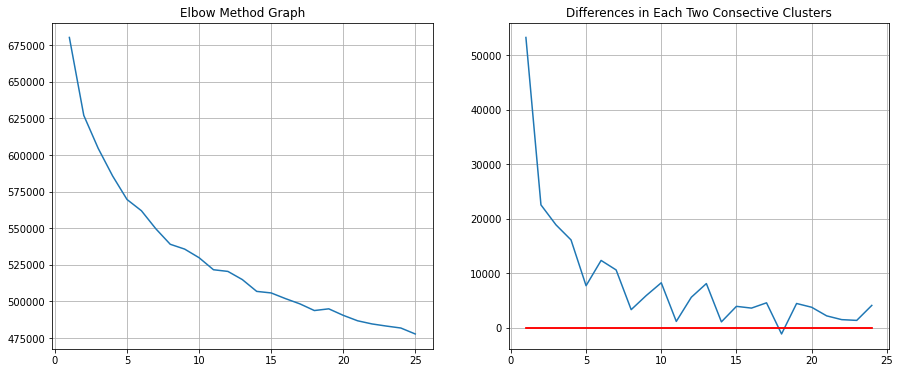

In [27]:
elbow_method = elbowMethod(sparseMatrix)
elbow_method.run(1, 25)
elbow_method.showPlot(boundary = 10)



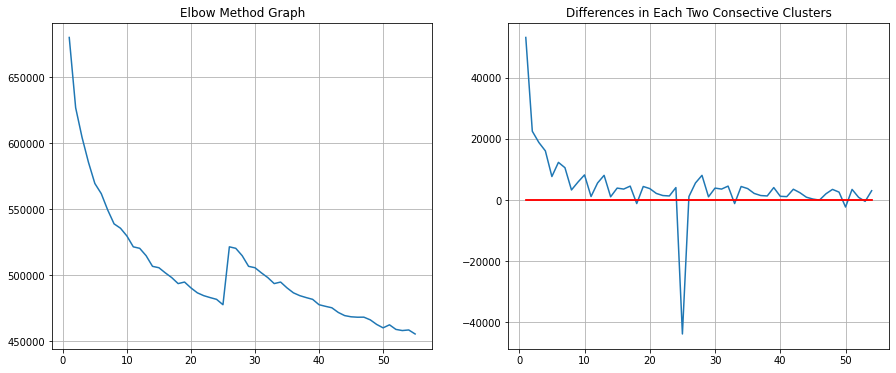

In [28]:
elbow_method.run(11, 40)
elbow_method.showPlot(boundary = 10)



In [29]:
kmeans = KMeans(n_clusters=25, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
clusters = kmeans.fit_predict(sparseMatrix)

In [133]:
kmeans.cluster_centers_

array([[ 1.00000000e+00,  2.29874273e-02,  2.62713455e-03, ...,
         4.69131169e-03, -1.07200490e-17,  7.50609871e-04],
       [ 3.00928359e-01,  5.44753897e-02,  2.45226835e-03, ...,
         6.16570328e-02,  1.75162025e-04,  1.57645822e-03],
       [ 4.17098446e-01,  1.06865285e-01,  2.59067358e-03, ...,
         8.20379965e-03,  2.03287907e-18,  2.15889465e-04],
       ...,
       [ 4.77625855e-01,  2.20633934e-01,  3.16967060e-02, ...,
         1.24300808e-03,  1.36880524e-18,  1.24300808e-03],
       [ 1.44433688e-01,  2.17231365e-01,  4.64666021e-03, ...,
         7.74443369e-04,  1.93610842e-04,  1.51788304e-18],
       [ 2.50982879e-01,  5.30120482e-02,  5.07292327e-04, ...,
         6.34115409e-04, -5.97666448e-18,  1.26823082e-04]])

In [31]:
users_cluster = pd.DataFrame(np.concatenate((users.reshape(-1,1), clusters.reshape(-1,1)), axis = 1), columns = ['userId', 'Cluster'])
users_cluster.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,162936,162937,162938,162939,162940,162941,162942,162943,162944,162945,162946,162947,162948,162949,162950,162951,162952,162953,162954,162955,162956,162957,162958,162959,162960,162961,162962,162963,162964,162965,162966,162967,162968,162969,162970,162971,162972,162973,162974,162975
userId,1,2,8,9,10,11,12,15,16,18,20,22,24,25,27,28,29,30,33,34,35,36,37,40,41,43,44,46,47,49,51,52,53,54,55,56,58,59,60,62,...,270833,270834,270835,270836,270837,270840,270843,270844,270846,270847,270849,270850,270851,270852,270854,270857,270858,270859,270860,270861,270863,270867,270868,270869,270871,270872,270875,270876,270877,270879,270882,270883,270885,270887,270891,270892,270893,270894,270895,270896
Cluster,4,4,0,24,24,4,15,4,1,4,23,6,17,4,3,7,14,11,23,8,4,4,24,0,4,4,24,24,15,12,0,19,9,4,24,20,12,7,4,2,...,6,5,9,14,4,6,4,7,24,10,2,13,8,7,4,19,3,9,21,14,0,6,14,9,20,3,0,4,13,4,6,3,1,13,22,19,21,9,23,1


In [73]:
def clustersMovies(users_cluster, users_data):
    clusters = list(users_cluster['Cluster'])
    each_cluster_movies = list()
    for i in range(len(np.unique(clusters))):
        users_list = list(users_cluster[users_cluster['Cluster'] == i]['userId'])
        users_movies_list = list()
        for user in users_list:    
            users_movies_list.extend(list(users_data[users_data['userId'] == user]['movieId']))
        users_movies_counts = list()
        users_movies_counts.extend([[movie, users_movies_list.count(movie)] for movie in np.unique(users_movies_list)])
        each_cluster_movies.append(pd.DataFrame(users_movies_counts, columns=['movieId', 'Count']).sort_values(by = ['Count'], ascending = False).reset_index(drop=True))
    return each_cluster_movies


In [74]:
cluster_movies = clustersMovies(users_cluster, users_fav_movies)


In [75]:
cluster_movies[1].T


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179
movieId,50,47,32,111,1,29,6,25,16,165,36,34,70,21,162,110,97,39,194,198,163,10,101,180,123,58,17,104,150,141,161,175,2,18,52,45,154,176,147,153,...,64,140,77,8,191,126,179,40,102,116,115,9,134,132,129,66,182,127,54,113,93,61,38,148,169,189,114,33,181,51,174,130,137,84,138,87,90,53,98,128
Count,5267,5094,4710,3815,1718,927,746,688,621,531,497,491,459,447,404,399,352,347,336,313,313,311,309,277,273,268,264,255,254,241,236,228,206,202,171,154,152,144,138,135,...,5,4,4,4,4,4,4,4,4,4,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [76]:
for i in range(15):
    len_users = users_cluster[users_cluster['Cluster'] == i].shape[0]
    print('Users in Cluster ' + str(i) + ' -> ', len_users)

Users in Cluster 0 ->  10658
Users in Cluster 1 ->  5709
Users in Cluster 2 ->  4632
Users in Cluster 3 ->  7092
Users in Cluster 4 ->  29539
Users in Cluster 5 ->  3752
Users in Cluster 6 ->  12207
Users in Cluster 7 ->  11871
Users in Cluster 8 ->  4042
Users in Cluster 9 ->  6777
Users in Cluster 10 ->  4660
Users in Cluster 11 ->  4225
Users in Cluster 12 ->  3595
Users in Cluster 13 ->  2005
Users in Cluster 14 ->  5597


In [77]:
def getMoviesOfUser(user_id, users_data):
    return list(users_data[users_data['userId'] == user_id]['movieId'])

In [78]:
def fixClusters(clusters_movies_dataframes, users_cluster_dataframe, users_data, smallest_cluster_size = 11):
    # clusters_movies_dataframes: will be a list which will contain each dataframes of each cluster movies
    # users_cluster_dataframe: will be a dataframe which contain users IDs and their cluster no.
    # smallest_cluster_size: is a smallest cluster size which we want for a cluster to not remove
    each_cluster_movies = clusters_movies_dataframes.copy()
    users_cluster = users_cluster_dataframe.copy()
    # Let convert dataframe in each_cluster_movies to list with containing only movies IDs
    each_cluster_movies_list = [list(df['movieId']) for df in each_cluster_movies]
    # First we will prepair a list which containt lists of users in each cluster -> [[Cluster 0 Users], [Cluster 1 Users], ... ,[Cluster N Users]] 
    usersInClusters = list()
    total_clusters = len(each_cluster_movies)
    for i in range(total_clusters):
        usersInClusters.append(list(users_cluster[users_cluster['Cluster'] == i]['userId']))
    uncategorizedUsers = list()
    i = 0
    # Now we will remove small clusters and put their users into another list named "uncategorizedUsers"
    # Also when we will remove a cluster, then we have also bring back cluster numbers of users which comes after deleting cluster
    # E.g. if we have deleted cluster 4 then their will be users whose clusters will be 5,6,7,..,N. So, we'll bring back those users cluster number to 4,5,6,...,N-1.
    for j in range(total_clusters):
        if len(usersInClusters[i]) < smallest_cluster_size:
            uncategorizedUsers.extend(usersInClusters[i])
            usersInClusters.pop(i)
            each_cluster_movies.pop(i)
            each_cluster_movies_list.pop(i)
            users_cluster.loc[users_cluster['Cluster'] > i, 'Cluster'] -= 1
            i -= 1
        i += 1
    for user in uncategorizedUsers:
        elemProbability = list()
        user_movies = getMoviesOfUser(user, users_data)
        if len(user_movies) == 0:
            print(user)
        user_missed_movies = list()
        for movies_list in each_cluster_movies_list:
            count = 0
            missed_movies = list()
            for movie in user_movies:
                if movie in movies_list:
                    count += 1
                else:
                    missed_movies.append(movie)
            elemProbability.append(count / len(user_movies))
            user_missed_movies.append(missed_movies)
        user_new_cluster = np.array(elemProbability).argmax()
        users_cluster.loc[users_cluster['userId'] == user, 'Cluster'] = user_new_cluster
        if len(user_missed_movies[user_new_cluster]) > 0:
            each_cluster_movies[user_new_cluster] = each_cluster_movies[user_new_cluster].append([{'movieId': new_movie, 'Count': 1} for new_movie in user_missed_movies[user_new_cluster]], ignore_index = True)
    return each_cluster_movies, users_cluster

In [79]:
movies_df_fixed, clusters_fixed = fixClusters(cluster_movies, users_cluster, users_fav_movies, smallest_cluster_size = 6)


In [81]:
j = 0
for i in range(15):
    len_users = users_cluster[users_cluster['Cluster'] == i].shape[0]
    if len_users < 6:
        print('Users in Cluster ' + str(i) + ' -> ', len_users)
        j += 1
print('Total Cluster which we want to remove -> ', j)

Total Cluster which we want to remove ->  0


In [82]:
print('Length of total clusters before fixing is -> ', len(cluster_movies))
print('Max value in users_cluster dataframe column Cluster is -> ', users_cluster['Cluster'].max())
print('And dataframe is following')
users_cluster.T

Length of total clusters before fixing is ->  25
Max value in users_cluster dataframe column Cluster is ->  24
And dataframe is following


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,162936,162937,162938,162939,162940,162941,162942,162943,162944,162945,162946,162947,162948,162949,162950,162951,162952,162953,162954,162955,162956,162957,162958,162959,162960,162961,162962,162963,162964,162965,162966,162967,162968,162969,162970,162971,162972,162973,162974,162975
userId,1,2,8,9,10,11,12,15,16,18,20,22,24,25,27,28,29,30,33,34,35,36,37,40,41,43,44,46,47,49,51,52,53,54,55,56,58,59,60,62,...,270833,270834,270835,270836,270837,270840,270843,270844,270846,270847,270849,270850,270851,270852,270854,270857,270858,270859,270860,270861,270863,270867,270868,270869,270871,270872,270875,270876,270877,270879,270882,270883,270885,270887,270891,270892,270893,270894,270895,270896
Cluster,4,4,0,24,24,4,15,4,1,4,23,6,17,4,3,7,14,11,23,8,4,4,24,0,4,4,24,24,15,12,0,19,9,4,24,20,12,7,4,2,...,6,5,9,14,4,6,4,7,24,10,2,13,8,7,4,19,3,9,21,14,0,6,14,9,20,3,0,4,13,4,6,3,1,13,22,19,21,9,23,1


In [84]:
print('Users cluster dataFrame for cluster 11 before fixing:')
users_cluster[users_cluster['Cluster'] == 11].T

Users cluster dataFrame for cluster 11 before fixing:


,17,44,84,101,166,172,183,203,222,233,264,292,663,702,705,718,725,767,857,922,956,1166,1171,1172,1290,1340,1396,1420,1429,1445,1496,1526,1531,1700,1757,1793,1893,1975,1992,2012,...,161348,161363,161459,161462,161490,161493,161517,161590,161609,161622,161639,161643,161713,161741,161774,161842,161905,161922,161966,161994,162219,162260,162261,162271,162380,162438,162457,162470,162516,162648,162676,162690,162728,162749,162756,162763,162784,162821,162858,162933
userId,30,68,127,160,284,298,318,342,368,384,432,479,1095,1147,1150,1166,1177,1242,1399,1529,1588,1944,1953,1954,2159,2236,2329,2366,2382,2406,2485,2527,2535,2816,2906,2970,3127,3265,3291,3327,...,268105,268134,268295,268300,268346,268352,268385,268511,268542,268562,268584,268596,268712,268769,268813,268936,269049,269077,269148,269203,269583,269658,269660,269676,269870,269969,270001,270035,270103,270326,270375,270397,270469,270505,270516,270526,270559,270615,270678,270829
Cluster,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11


In [85]:
print('Users cluster dataFrame for cluster 4 after fixing which should be same as 11th cluster before fixing:')
clusters_fixed[clusters_fixed['Cluster'] == 4].T

Users cluster dataFrame for cluster 4 after fixing which should be same as 11th cluster before fixing:


,0,1,5,7,9,13,20,21,24,25,33,38,46,53,57,58,71,77,78,91,106,109,112,113,124,125,126,130,134,150,152,153,158,159,160,168,174,177,181,186,...,162750,162760,162764,162767,162786,162793,162796,162798,162800,162804,162809,162813,162819,162824,162841,162851,162855,162860,162866,162879,162881,162885,162891,162892,162894,162900,162901,162905,162906,162907,162912,162922,162928,162930,162931,162940,162942,162950,162963,162965
userId,1,2,11,15,18,25,35,36,41,43,54,60,70,77,84,87,107,117,118,137,168,176,181,182,203,207,211,219,228,257,264,266,274,275,276,293,303,311,316,321,...,270506,270523,270528,270532,270561,270573,270576,270578,270582,270588,270597,270604,270612,270620,270648,270666,270675,270680,270690,270713,270721,270727,270735,270738,270745,270755,270756,270763,270764,270768,270777,270801,270817,270825,270827,270837,270843,270854,270876,270879
Cluster,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4


In [86]:
print('Size of movies dataframe after fixing -> ', len(movies_df_fixed))


Size of movies dataframe after fixing ->  25


In [87]:
for i in range(len(movies_df_fixed)):
    len_users = clusters_fixed[clusters_fixed['Cluster'] == i].shape[0]
    print('Users in Cluster ' + str(i) + ' -> ', len_users)

Users in Cluster 0 ->  10658
Users in Cluster 1 ->  5709
Users in Cluster 2 ->  4632
Users in Cluster 3 ->  7092
Users in Cluster 4 ->  29539
Users in Cluster 5 ->  3752
Users in Cluster 6 ->  12207
Users in Cluster 7 ->  11871
Users in Cluster 8 ->  4042
Users in Cluster 9 ->  6777
Users in Cluster 10 ->  4660
Users in Cluster 11 ->  4225
Users in Cluster 12 ->  3595
Users in Cluster 13 ->  2005
Users in Cluster 14 ->  5597
Users in Cluster 15 ->  3360
Users in Cluster 16 ->  1768
Users in Cluster 17 ->  2447
Users in Cluster 18 ->  3604
Users in Cluster 19 ->  8958
Users in Cluster 20 ->  4426
Users in Cluster 21 ->  5784
Users in Cluster 22 ->  3218
Users in Cluster 23 ->  5165
Users in Cluster 24 ->  7885


In [88]:
for i in range(len(movies_df_fixed)):
    print('Total movies in Cluster ' + str(i) + ' -> ', movies_df_fixed[i].shape[0])

Total movies in Cluster 0 ->  178
Total movies in Cluster 1 ->  180
Total movies in Cluster 2 ->  176
Total movies in Cluster 3 ->  176
Total movies in Cluster 4 ->  186
Total movies in Cluster 5 ->  169
Total movies in Cluster 6 ->  175
Total movies in Cluster 7 ->  170
Total movies in Cluster 8 ->  178
Total movies in Cluster 9 ->  160
Total movies in Cluster 10 ->  189
Total movies in Cluster 11 ->  177
Total movies in Cluster 12 ->  182
Total movies in Cluster 13 ->  187
Total movies in Cluster 14 ->  185
Total movies in Cluster 15 ->  189
Total movies in Cluster 16 ->  174
Total movies in Cluster 17 ->  195
Total movies in Cluster 18 ->  169
Total movies in Cluster 19 ->  184
Total movies in Cluster 20 ->  171
Total movies in Cluster 21 ->  172
Total movies in Cluster 22 ->  186
Total movies in Cluster 23 ->  175
Total movies in Cluster 24 ->  171


In [91]:
import pandas as pd
print('Pandas version: ', pd.__version__)

import numpy as np
print('NumPy version: ', np.__version__)

import matplotlib
print('Matplotlib version: ', matplotlib.__version__)

from matplotlib import pyplot as plt

import sklearn
print('Scikit-Learn version: ', sklearn.__version__)

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.cluster import KMeans


import pickle
print('Pickle version: ', pickle.format_version)

import sys
print('Sys version: ', sys.version[0:5])

from sys import exc_info

import ast

Pandas version:  1.1.5
NumPy version:  1.19.5
Matplotlib version:  3.2.2
Scikit-Learn version:  0.24.1
Pickle version:  4.0
Sys version:  3.7.1


In [98]:
import pickle
print('Pickle version: ', pickle.format_version)

import sys
print('Sys version: ', sys.version[0:5])

from sys import exc_info

import ast

class saveLoadFiles:
    def save(self, filename, data):
        try:
            file = open('/content/sample_data' + filename + '.pkl', 'wb')
            pickle.dump(data, file)
        except:
            err = 'Error: {0}, {1}'.format(exc_info()[0], exc_info()[1])
            print(err)
            file.close()
            return [False, err]
        else:
            file.close()
            return [True]
    def load(self, filename):
        try:
            file = open('/content/sample_data' + filename + '.pkl', 'rb')
        except:
            err = 'Error: {0}, {1}'.format(exc_info()[0], exc_info()[1])
            print(err)
            file.close()
            return [False, err]
        else:
            data = pickle.load(file)
            file.close()
            return data
    def loadClusterMoviesDataset(self):
        return self.load('clusters_movies_dataset')
    def saveClusterMoviesDataset(self, data):
        return self.save('clusters_movies_dataset', data)
    def loadUsersClusters(self):
        return self.load('users_clusters')
    def saveUsersClusters(self, data):
        return self.save('users_clusters', data)

Pickle version:  4.0
Sys version:  3.7.1


In [99]:
saveLoadFile = saveLoadFiles()
print(saveLoadFile.saveClusterMoviesDataset(movies_df_fixed))
print(saveLoadFile.saveUsersClusters(clusters_fixed))

[True]
[True]


In [100]:
load_movies_list, load_users_clusters = saveLoadFile.loadClusterMoviesDataset(), saveLoadFile.loadUsersClusters()
print('Type of Loading list of Movies dataframes of 5 Clusters: ', type(load_movies_list), ' and Length is: ', len(load_movies_list))
print('Type of Loading 100 Users clusters Data: ', type(load_users_clusters), ' and Shape is: ', load_users_clusters.shape)

Type of Loading list of Movies dataframes of 5 Clusters:  <class 'list'>  and Length is:  25
Type of Loading 100 Users clusters Data:  <class 'pandas.core.frame.DataFrame'>  and Shape is:  (162976, 2)


In [101]:
class userRequestedFor:
    def __init__(self, user_id, users_data):
        self.users_data = users_data.copy()
        self.user_id = user_id
        # Find User Cluster
        users_cluster = saveLoadFiles().loadUsersClusters()
        self.user_cluster = int(users_cluster[users_cluster['userId'] == self.user_id]['Cluster'])
        # Load User Cluster Movies Dataframe
        self.movies_list = saveLoadFiles().loadClusterMoviesDataset()
        self.cluster_movies = self.movies_list[self.user_cluster] # dataframe
        self.cluster_movies_list = list(self.cluster_movies['movieId']) # list
    def updatedFavouriteMoviesList(self, new_movie_Id):
        if new_movie_Id in self.cluster_movies_list:
            self.cluster_movies.loc[self.cluster_movies['movieId'] == new_movie_Id, 'Count'] += 1
        else:
            self.cluster_movies = self.cluster_movies.append([{'movieId':new_movie_Id, 'Count': 1}], ignore_index=True)
        self.cluster_movies.sort_values(by = ['Count'], ascending = False, inplace= True)
        self.movies_list[self.user_cluster] = self.cluster_movies
        saveLoadFiles().saveClusterMoviesDataset(self.movies_list)

    def recommendMostFavouriteMovies(self):
        try:
            user_movies = getMoviesOfUser(self.user_id, self.users_data)
            cluster_movies_list = self.cluster_movies_list.copy()
            for user_movie in user_movies:
                if user_movie in cluster_movies_list:
                    cluster_movies_list.remove(user_movie)
            return [True, cluster_movies_list]
        except KeyError:
            err = "User history does not exist"
            print(err)
            return [False, err]
        except:
            err = 'Error: {0}, {1}'.format(exc_info()[0], exc_info()[1])
            print(err)
            return [False, err]

In [105]:
movies=pd.read_csv('movies_metadata.csv')
movies.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [108]:
movies_metadata = pd.read_csv('movies_metadata.csv', 
    usecols = ['id', 'genres', 'original_title'])

movies_metadata = movies_metadata.loc[
    movies_metadata['id'].isin(list(map(str, np.unique(users_fav_movies['movieId']))))].reset_index(drop=True)
print('Let take a look at movie metadata for all those movies which we were had in our dataset')

Let take a look at movie metadata for all those movies which we were had in our dataset


In [109]:
user12Movies = getMoviesOfUser(12, users_fav_movies)
for movie in user12Movies:
    title = list(movies_metadata.loc[movies_metadata['id'] == str(movie)]['original_title'])
    if title != []:
        print('Movie title: ', title, ', Genres: [', end = '')
        genres = ast.literal_eval(movies_metadata.loc[movies_metadata['id'] == str(movie)]['genres'].values[0].split('[')[1].split(']')[0])
        for genre in genres:
            print(genre['name'], ', ', end = '')
        print(end = '\b\b]')
        print('')

Movie title:  ['Dancer in the Dark'] , Genres: [Drama , Crime , Music , ]
Movie title:  ['The Dark'] , Genres: [Horror , Thriller , Mystery , ]
Movie title:  ['Miami Vice'] , Genres: [Action , Adventure , Crime , Thriller , ]
Movie title:  ['Tron'] , Genres: [Science Fiction , Action , Adventure , ]
Movie title:  ['The Lord of the Rings'] , Genres: [Fantasy , Drama , Animation , Adventure , ]
Movie title:  ['48 Hrs.'] , Genres: [Thriller , Action , Comedy , Crime , Drama , ]
Movie title:  ['Edward Scissorhands'] , Genres: [Fantasy , Drama , Romance , ]
Movie title:  ['Le Grand Bleu'] , Genres: [Adventure , Drama , Romance , ]
Movie title:  ['Saw'] , Genres: [Horror , Mystery , Crime , ]
Movie title:  ["Le fabuleux destin d'Amélie Poulain"] , Genres: [Comedy , Romance , ]


In [132]:
user12Recommendations = userRequestedFor(12, users_fav_movies).recommendMostFavouriteMovies()[1]
for movie in user12Recommendations[:15]:
    title = list(movies_metadata.loc[movies_metadata['id'] == str(movie)]['original_title'])
    if title != []:
        print('Movie title: ', title, ', genres: [', end = '')
        genres = ast.literal_eval(movies_metadata.loc[movies_metadata['id'] == str(movie)]['genres'].values[0].split('[')[1].split(']')[0])
        for genre in genres:
            print('\b')
            print(genre)
        print(end = '\b\b]')
        print('')

Movie title:  ['The Endless Summer'] , genres: [
id

name
]
Movie title:  ['Scarface'] , genres: [
{'id': 28, 'name': 'Action'}

{'id': 80, 'name': 'Crime'}

{'id': 18, 'name': 'Drama'}

{'id': 53, 'name': 'Thriller'}
]
Movie title:  ['Jarhead'] , genres: [
{'id': 18, 'name': 'Drama'}

{'id': 10752, 'name': 'War'}
]
Movie title:  ["Pirates of the Caribbean: Dead Man's Chest"] , genres: [
{'id': 12, 'name': 'Adventure'}

{'id': 14, 'name': 'Fantasy'}

{'id': 28, 'name': 'Action'}
]
Movie title:  ['Trois couleurs : Rouge'] , genres: [
{'id': 18, 'name': 'Drama'}

{'id': 9648, 'name': 'Mystery'}

{'id': 10749, 'name': 'Romance'}
]
Movie title:  ['Star Wars'] , genres: [
{'id': 12, 'name': 'Adventure'}

{'id': 28, 'name': 'Action'}

{'id': 878, 'name': 'Science Fiction'}
]
Movie title:  ['Apocalypse Now'] , genres: [
{'id': 18, 'name': 'Drama'}

{'id': 10752, 'name': 'War'}
]
Movie title:  ['Donnie Darko'] , genres: [
{'id': 14, 'name': 'Fantasy'}

{'id':